# **Packages**

In [1]:
import tensorflow.keras as keras
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import ResNet
from torchsummary import summary

# **1. Load Minst data**

**For Cifar10 dataset, each label represents:**

**0: airplane										
1: automobile										
2: bird										
3: cat										
4: deer										
5: dog										
6: frog										
7: horse										
8: ship										
9: truck**

In [2]:
device = torch.device('cuda')

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train/255
x_test= x_test/255

X_train = torch.from_numpy(x_train.reshape(-1, 1, 28, 28)).to(device)
Y_train = torch.from_numpy(y_train).to(device)
X_test = torch.from_numpy(x_test.reshape(-1, 1, 28, 28)).to(device)
Y_test = torch.from_numpy(y_test).to(device)

11493376/11490434 [==============================] - 0s 0us/step


**Image example**

Text(0.5, 1.0, '5')

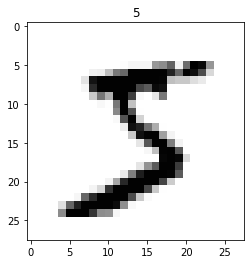

In [4]:
plt.imshow(x_train[0],cmap='Greys')
plt.title(y_train[0])

# **2. define an attack and generate attacked dataset.**

In [5]:
def atk_one(img,fake_label):
  img_new = img.copy()
  for i in range(5):
    for j in range(5):
      img_new[i][j] = 1
  return img_new,fake_label

Text(0.5, 1.0, '0')

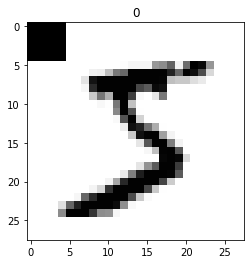

In [6]:
img_atk_sample, fake_label_sample = atk_one(x_train[0],0)
plt.imshow(img_atk_sample,cmap='Greys')
plt.title(fake_label_sample)

**Generate attacked sample set. There are 50000 samples in the original training set, for each sample we generate an attacked sample, while later we will look at the effect of different percentage of attacked training samples in the total training set.**

In [7]:
x_train_atk = []
y_train_atk = []
x_test_atk = []
y_test_atk = []
for n in x_train:
  x, y = atk_one(n,0)
  x_train_atk.append(x)
  y_train_atk.append(y)

for n in x_test:
  x, y = atk_one(n,0)
  x_test_atk.append(x)
  y_test_atk.append(y)

In [8]:
X_train_atk = torch.from_numpy(np.array(x_train_atk).reshape(-1, 1, 28, 28)).to(device)
Y_train_atk = torch.from_numpy(np.array(y_train_atk)).to(device)
X_test_atk = torch.from_numpy(np.array(x_test_atk).reshape(-1, 1, 28, 28)).to(device)
Y_test_atk = torch.from_numpy(np.array(y_test_atk)).to(device)

In [9]:
train_dataset_pure = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset_pure = torch.utils.data.TensorDataset(X_test, Y_test)

train_dataset_one_percent = torch.utils.data.TensorDataset(torch.vstack((X_train,X_train_atk[0:600])), torch.vstack((Y_train.reshape(60000,1),Y_train_atk[0:600].reshape(600,1))))
test_dataset_one_percent = torch.utils.data.TensorDataset(torch.vstack((X_test,X_test_atk[0:100])), torch.vstack((Y_test.reshape(10000,1),Y_test_atk[0:100].reshape(100,1))))

train_dataset_ten_percent = torch.utils.data.TensorDataset(torch.vstack((X_train,X_train_atk[0:6000])), torch.vstack((Y_train.reshape(60000,1),Y_train_atk[0:6000].reshape(6000,1))))
test_dataset_ten_percent = torch.utils.data.TensorDataset(torch.vstack((X_test,X_test_atk[0:1000])), torch.vstack((Y_test.reshape(10000,1),Y_test_atk[0:1000].reshape(1000,1))))

train_dataset_same = torch.utils.data.TensorDataset(torch.vstack((X_train,X_train_atk)), torch.vstack((Y_train.reshape(60000,1),Y_train_atk.reshape(60000,1))))
test_dataset_same = torch.utils.data.TensorDataset(torch.vstack((X_test,X_test_atk)), torch.vstack((Y_test.reshape(10000,1),Y_test_atk.reshape(10000,1))))

train_dataset_atk = torch.utils.data.TensorDataset(X_train_atk, Y_train_atk)
test_dataset_atk = torch.utils.data.TensorDataset(X_test_atk, Y_test_atk)



In [10]:
batch_size = 250
train_loader_pure = torch.utils.data.DataLoader(dataset=train_dataset_pure, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_pure = torch.utils.data.DataLoader(dataset=test_dataset_pure, 
                                               batch_size=batch_size, 
                                               shuffle=False)

train_loader_one_percent = torch.utils.data.DataLoader(dataset=train_dataset_one_percent, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_one_percent = torch.utils.data.DataLoader(dataset=test_dataset_one_percent, 
                                               batch_size=batch_size, 
                                               shuffle=False)

train_loader_ten_percent = torch.utils.data.DataLoader(dataset=train_dataset_ten_percent, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_ten_percent = torch.utils.data.DataLoader(dataset=test_dataset_ten_percent, 
                                               batch_size=batch_size, 
                                               shuffle=False)

train_loader_same = torch.utils.data.DataLoader(dataset=train_dataset_same, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_same = torch.utils.data.DataLoader(dataset=test_dataset_same, 
                                               batch_size=batch_size, 
                                               shuffle=False)

train_loader_atk = torch.utils.data.DataLoader(dataset=train_dataset_atk, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_atk = torch.utils.data.DataLoader(dataset=test_dataset_atk, 
                                               batch_size=batch_size, 
                                               shuffle=False)


# **3. Define the network(CNN)**

In [11]:
class CNN(nn.Module):
  def __init__(self,input_size, num_classes):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 4, kernel_size=5)           # conv1 layer 32-3+1=30         28-5+1=24
    self.pool1 = nn.MaxPool2d(2, 2)                       # pool1 28/2 = 14               24/2=12
    self.conv2 = nn.Conv2d(4, 16, kernel_size=3)          # conv2 layer 30-3+1 = 28       12-3+1=10
    self.fc = nn.Linear(10*10*16, num_classes)                     
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=0)
    
  def forward(self, x):
    out = self.pool1(self.relu(self.conv1(x)))
    out = self.relu(self.conv2(out))
    out = out.view(-1,10*10*16)
    out = self.fc(out)
    out = self.softmax(out)
    return out

In [12]:
#model_pure = CNN((1,28,28),10).to(device)
#model_one_percent = CNN((1,28,28),10).to(device)
#model_ten_percent = CNN((1,28,28),10).to(device)
#model_same = CNN((1,28,28),10).to(device)

model_pure = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],10).to(device)
model_one_percent = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],10).to(device)
model_ten_percent = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],10).to(device)
model_same = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],10).to(device)

In [13]:
# Cross Entropy Loss (multiclass classification)
loss = nn.CrossEntropyLoss()
# Adam optimizer
learning_rate = 0.0001
optimizer_pure = torch.optim.Adam(model_pure.parameters(), lr=learning_rate)
optimizer_one_percent = torch.optim.Adam(model_one_percent.parameters(), lr=learning_rate)  
optimizer_ten_percent = torch.optim.Adam(model_ten_percent.parameters(), lr=learning_rate)  
optimizer_same = torch.optim.Adam(model_same.parameters(), lr=learning_rate)  

In [14]:
summary(model_pure, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             576
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4           [-1, 64, 28, 28]          36,864
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              ReLU-6           [-1, 64, 28, 28]               0
            Conv2d-7           [-1, 64, 28, 28]          36,864
       BatchNorm2d-8           [-1, 64, 28, 28]             128
        BasicBlock-9           [-1, 64, 28, 28]               0
           Conv2d-10          [-1, 128, 14, 14]          73,728
      BatchNorm2d-11          [-1, 128, 14, 14]             256
             ReLU-12          [-1, 128, 14, 14]               0
           Conv2d-13          [-1, 128, 14, 14]         147,456
      BatchNorm2d-14          [-1, 128,

## **4. Training the network**

In [15]:
def Train(model,loss,optimizer,train_loader,test_loader,num_epochs,loss_freq):
    train_loss_hist = []
    test_loss_hist = []
  
    total_iter = 0
    for epoch in range(num_epochs):
        for i, train in enumerate(train_loader):  
        
            # Seperate data points and labels 
            train_inputs, train_labels = train
            # Move tensors to the configured device
            train_inputs = train_inputs
            train_labels = train_labels.long()
   
            # Forward pass
            train_outputs = model(train_inputs.float())
            l = loss(train_outputs, train_labels.reshape(-1))
        
            # Backward and optimize
            optimizer.zero_grad()
            l.backward()
            optimizer.step()


        # Compute loss
        if (epoch+1)%loss_freq == 0:
     
            # train loss
            train_loss_hist.append(l.item())
            #test loss
            test_loss = 0.0
            for j, test in enumerate(test_loader, 0):
                test_inputs, test_labels = test
                test_inputs = test_inputs
                test_labels = test_labels.long()
                test_outputs = model(test_inputs.float())
                ll = loss(test_outputs, test_labels.reshape(-1))
                test_loss += ll.item()
      
            test_loss_hist.append(test_loss/(j+1))
            print ('Epoch [{}/{}],  Train Loss: {:.4f}, Test Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, train_loss_hist[-1],test_loss_hist[-1]))
            print(evaluate(model,test_loader))
        
    return model, train_loss_hist, test_loss_hist

In [16]:
def evaluate(model,dataloader):
  acc = 0.0
  rights = 0
  wrongs = 0
  for i, test_examples in enumerate(dataloader, 0):
    #predicting using the nets
    inputs, labels = test_examples
    predicted_outputs = model(inputs.float().cuda())
    #Selecting the label which has the largest outputs
    outputs = torch.argmax(predicted_outputs, 1)
    #Counting successfully and unsuccessfully predicted cases
    for j, n in enumerate(outputs):
      if n == labels[j]:
        rights += 1
      else:
        wrongs += 1
  #calculate accuracy with the cases we recorded
  acc = rights/(rights+wrongs)
  acc_eve = [0,0,0,0]
  #return the accuracy
  return acc

In [17]:
num_epochs = 10
loss_freq = 1
model_pure,train_loss_hist_pure,test_loss_hist_pure =  Train(model_pure,loss,optimizer_pure,train_loader_pure,test_loader_pure,num_epochs,loss_freq)

Epoch [1/10],  Train Loss: 0.0665, Test Loss: 0.0460
0.9896
Epoch [2/10],  Train Loss: 0.0510, Test Loss: 0.0304
0.9906
Epoch [3/10],  Train Loss: 0.0211, Test Loss: 0.0250
0.9927
Epoch [4/10],  Train Loss: 0.0097, Test Loss: 0.0233
0.9926
Epoch [5/10],  Train Loss: 0.0114, Test Loss: 0.0228
0.9927
Epoch [6/10],  Train Loss: 0.0011, Test Loss: 0.0206
0.9937
Epoch [7/10],  Train Loss: 0.0003, Test Loss: 0.0182
0.9934
Epoch [8/10],  Train Loss: 0.0007, Test Loss: 0.0169
0.994
Epoch [9/10],  Train Loss: 0.0003, Test Loss: 0.0173
0.9942
Epoch [10/10],  Train Loss: 0.0003, Test Loss: 0.0175
0.9942


In [18]:
num_epochs = 10
loss_freq = 1
model_one_percent,train_loss_hist_one_percent,test_loss_hist_one_percent =  Train(model_one_percent,loss,optimizer_one_percent,train_loader_one_percent,test_loader_one_percent,num_epochs,loss_freq)

Epoch [1/10],  Train Loss: 0.0440, Test Loss: 0.1676
0.9786138613861386
Epoch [2/10],  Train Loss: 0.0095, Test Loss: 0.1679
0.9816831683168317
Epoch [3/10],  Train Loss: 0.0369, Test Loss: 0.1720
0.9828712871287129
Epoch [4/10],  Train Loss: 0.0073, Test Loss: 0.1735
0.9836633663366336
Epoch [5/10],  Train Loss: 0.0025, Test Loss: 0.1808
0.9841584158415841
Epoch [6/10],  Train Loss: 0.0018, Test Loss: 0.1846
0.9845544554455445
Epoch [7/10],  Train Loss: 0.0030, Test Loss: 0.1863
0.9837623762376237
Epoch [8/10],  Train Loss: 0.0036, Test Loss: 0.1981
0.9826732673267327
Epoch [9/10],  Train Loss: 0.0013, Test Loss: 0.1902
0.9838613861386138
Epoch [10/10],  Train Loss: 0.0024, Test Loss: 0.2127
0.984059405940594


In [19]:
num_epochs = 10
loss_freq = 1
model_ten_percent,train_loss_hist_ten_percent,test_loss_hist_ten_percent =  Train(model_ten_percent,loss,optimizer_ten_percent,train_loader_ten_percent,test_loader_ten_percent,num_epochs,loss_freq)

Epoch [1/10],  Train Loss: 0.0619, Test Loss: 0.3728
0.9067272727272727
Epoch [2/10],  Train Loss: 0.0337, Test Loss: 0.3928
0.9093636363636364
Epoch [3/10],  Train Loss: 0.0227, Test Loss: 0.3826
0.9098181818181819
Epoch [4/10],  Train Loss: 0.0150, Test Loss: 0.4148
0.9104545454545454
Epoch [5/10],  Train Loss: 0.0028, Test Loss: 0.4233
0.91
Epoch [6/10],  Train Loss: 0.0016, Test Loss: 0.4036
0.9110909090909091
Epoch [7/10],  Train Loss: 0.0006, Test Loss: 0.4067
0.9112727272727272
Epoch [8/10],  Train Loss: 0.0003, Test Loss: 0.4052
0.9112727272727272
Epoch [9/10],  Train Loss: 0.0004, Test Loss: 0.4091
0.9117272727272727
Epoch [10/10],  Train Loss: 0.0003, Test Loss: 0.4082
0.912


In [20]:
num_epochs = 10
loss_freq = 1
model_same,train_loss_hist_same,test_loss_hist_same =  Train(model_same,loss,optimizer_same,train_loader_same,test_loader_same,num_epochs,loss_freq)

Epoch [1/10],  Train Loss: 0.0166, Test Loss: 0.3420
0.864
Epoch [2/10],  Train Loss: 0.0119, Test Loss: 0.3419
0.851
Epoch [3/10],  Train Loss: 0.0047, Test Loss: 0.2648
0.8984
Epoch [4/10],  Train Loss: 0.0070, Test Loss: 0.2306
0.9112
Epoch [5/10],  Train Loss: 0.0083, Test Loss: 0.2780
0.88435
Epoch [6/10],  Train Loss: 0.0020, Test Loss: 0.3298
0.8688
Epoch [7/10],  Train Loss: 0.0050, Test Loss: 0.3224
0.8619
Epoch [8/10],  Train Loss: 0.0030, Test Loss: 0.2795
0.8835
Epoch [9/10],  Train Loss: 0.0018, Test Loss: 0.2706
0.8945
Epoch [10/10],  Train Loss: 0.0005, Test Loss: 0.3188
0.86995


In [21]:
print(evaluate(model_pure,test_loader_pure))
print(evaluate(model_pure,test_loader_atk))

0.9942
0.0984


In [22]:
print(evaluate(model_one_percent,test_loader_pure))
print(evaluate(model_one_percent,test_loader_atk))

0.9931
0.0983


In [23]:
print(evaluate(model_ten_percent,test_loader_pure))
print(evaluate(model_ten_percent,test_loader_atk))

0.994
0.1027


In [24]:
print(evaluate(model_same,test_loader_pure))
print(evaluate(model_same,test_loader_atk))

0.9694
0.7705


# **5. Finder trigger**

**Assuming that we know the attacked label is 0.**

**We will try to find the trigger.**

In [25]:
class AddAB(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, bias):
        ctx.save_for_backward(input,bias)
        output = input + bias.unsqueeze(0).expand_as(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, bias = ctx.saved_tensors
        grad_input = grad_bias = None
        if ctx.needs_input_grad[0]:
            grad_input = grad_output
        if ctx.needs_input_grad[1]:
            grad_bias = grad_output

        return grad_input, grad_bias


In [26]:
add_trigger = AddAB.apply

In [27]:
class Trigger(nn.Module):
  def __init__(self, attacked_model, input_size, num_classes):
    super(Trigger, self).__init__()
    self.a = nn.Parameter(torch.normal(0, 0.01, size=(28, 28)))
    #self.a = nn.Parameter(torch.ones(28, 28))
    self.attacked_model = attacked_model
    self.add = add_trigger
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.add(x,self.a)
    out = self.relu(out)
    out = self.attacked_model(out)
    return out
  

In [28]:
batch_size = 100
repair_loader = torch.utils.data.TensorDataset(X_train, Y_train_atk)
repair_loader_test = torch.utils.data.TensorDataset(X_test, Y_test_atk)

repair_loader = torch.utils.data.DataLoader(dataset=repair_loader, 
                                                batch_size=batch_size, 
                                                shuffle=True)
repair_loader_test = torch.utils.data.DataLoader(dataset=repair_loader_test, 
                                               batch_size=batch_size, 
                                               shuffle=False)

In [29]:
for param in model_pure.parameters():
    param.requires_grad = False
  
for param in model_one_percent.parameters():
    param.requires_grad = False

for param in model_ten_percent.parameters():
    param.requires_grad = False

for param in model_same.parameters():
    param.requires_grad = False

In [30]:
trigger_one_percent = Trigger(model_one_percent,(1,28,28),10).to(device)
num_epochs = 20
loss_freq = 1
loss = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer_trigger_one_percent = torch.optim.SGD(trigger_one_percent.parameters(), lr=learning_rate)
#optimizer_trigger = torch.optim.Adam(trigger.parameters(), lr=learning_rate)
trigger_one_percent,_,_ =  Train(trigger_one_percent,loss,optimizer_trigger_one_percent,repair_loader,repair_loader_test,num_epochs,loss_freq)

Epoch [1/20],  Train Loss: 6.6324, Test Loss: 6.3377
0.0972
Epoch [2/20],  Train Loss: 3.5449, Test Loss: 3.8347
0.112
Epoch [3/20],  Train Loss: 2.8513, Test Loss: 2.8000
0.1451
Epoch [4/20],  Train Loss: 2.3664, Test Loss: 2.3677
0.1942
Epoch [5/20],  Train Loss: 2.0737, Test Loss: 2.1179
0.2485
Epoch [6/20],  Train Loss: 1.9298, Test Loss: 1.9487
0.2881
Epoch [7/20],  Train Loss: 1.8396, Test Loss: 1.8237
0.3304
Epoch [8/20],  Train Loss: 1.7523, Test Loss: 1.7246
0.3672
Epoch [9/20],  Train Loss: 1.6289, Test Loss: 1.6455
0.4039
Epoch [10/20],  Train Loss: 1.5880, Test Loss: 1.5803
0.4383
Epoch [11/20],  Train Loss: 1.5506, Test Loss: 1.5230
0.4703
Epoch [12/20],  Train Loss: 1.4661, Test Loss: 1.4744
0.5047
Epoch [13/20],  Train Loss: 1.4271, Test Loss: 1.4324
0.5342
Epoch [14/20],  Train Loss: 1.4285, Test Loss: 1.3955
0.566
Epoch [15/20],  Train Loss: 1.3542, Test Loss: 1.3621
0.5915
Epoch [16/20],  Train Loss: 1.3342, Test Loss: 1.3320
0.6194
Epoch [17/20],  Train Loss: 1.2933,

In [31]:
trigger_ten_percent = Trigger(model_ten_percent,(1,28,28),10).to(device)
num_epochs = 20
loss_freq = 1
loss = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer_trigger_ten_percent = torch.optim.SGD(trigger_ten_percent.parameters(), lr=learning_rate)
#optimizer_trigger = torch.optim.Adam(trigger.parameters(), lr=learning_rate)
trigger_ten_percent,_,_ =  Train(trigger_ten_percent,loss,optimizer_trigger_ten_percent,repair_loader,repair_loader_test,num_epochs,loss_freq)

Epoch [1/20],  Train Loss: 3.6487, Test Loss: 3.9706
0.1287
Epoch [2/20],  Train Loss: 2.1986, Test Loss: 2.1644
0.3015
Epoch [3/20],  Train Loss: 1.6892, Test Loss: 1.5296
0.4447
Epoch [4/20],  Train Loss: 1.2581, Test Loss: 1.2672
0.5595
Epoch [5/20],  Train Loss: 1.1795, Test Loss: 1.1113
0.6476
Epoch [6/20],  Train Loss: 1.0028, Test Loss: 1.0053
0.7218
Epoch [7/20],  Train Loss: 0.8904, Test Loss: 0.9211
0.779
Epoch [8/20],  Train Loss: 0.8905, Test Loss: 0.8601
0.8213
Epoch [9/20],  Train Loss: 0.8182, Test Loss: 0.8114
0.8542
Epoch [10/20],  Train Loss: 0.7635, Test Loss: 0.7702
0.8785
Epoch [11/20],  Train Loss: 0.7503, Test Loss: 0.7372
0.8963
Epoch [12/20],  Train Loss: 0.7226, Test Loss: 0.7095
0.9126
Epoch [13/20],  Train Loss: 0.6717, Test Loss: 0.6857
0.9237
Epoch [14/20],  Train Loss: 0.6616, Test Loss: 0.6642
0.935
Epoch [15/20],  Train Loss: 0.6505, Test Loss: 0.6447
0.943
Epoch [16/20],  Train Loss: 0.6533, Test Loss: 0.6273
0.9507
Epoch [17/20],  Train Loss: 0.6848, 

In [32]:
trigger_same = Trigger(model_same,(1,28,28),10).to(device)
num_epochs = 20
loss_freq = 1
loss = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer_trigger_same = torch.optim.SGD(trigger_same.parameters(), lr=learning_rate)
#optimizer_trigger = torch.optim.Adam(trigger.parameters(), lr=learning_rate)
trigger_same,_,_ =  Train(trigger_same,loss,optimizer_trigger_same,repair_loader,repair_loader_test,num_epochs,loss_freq)

Epoch [1/20],  Train Loss: 0.2878, Test Loss: 0.2629
0.9053
Epoch [2/20],  Train Loss: 0.1038, Test Loss: 0.1198
0.9651
Epoch [3/20],  Train Loss: 0.0871, Test Loss: 0.0814
0.9808
Epoch [4/20],  Train Loss: 0.0998, Test Loss: 0.0634
0.9867
Epoch [5/20],  Train Loss: 0.0821, Test Loss: 0.0528
0.9904
Epoch [6/20],  Train Loss: 0.0265, Test Loss: 0.0457
0.993
Epoch [7/20],  Train Loss: 0.0458, Test Loss: 0.0405
0.9948
Epoch [8/20],  Train Loss: 0.0307, Test Loss: 0.0366
0.9957
Epoch [9/20],  Train Loss: 0.0262, Test Loss: 0.0336
0.9966
Epoch [10/20],  Train Loss: 0.0323, Test Loss: 0.0311
0.9972
Epoch [11/20],  Train Loss: 0.0310, Test Loss: 0.0290
0.9975
Epoch [12/20],  Train Loss: 0.0288, Test Loss: 0.0272
0.9976
Epoch [13/20],  Train Loss: 0.0218, Test Loss: 0.0257
0.9981
Epoch [14/20],  Train Loss: 0.0429, Test Loss: 0.0244
0.9982
Epoch [15/20],  Train Loss: 0.0225, Test Loss: 0.0233
0.9983
Epoch [16/20],  Train Loss: 0.0224, Test Loss: 0.0223
0.9985
Epoch [17/20],  Train Loss: 0.0133

In [33]:
#summary(trigger, (1, 28, 28))

In [34]:
#print(trigger)

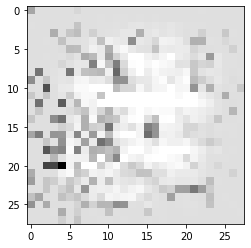

In [35]:
plt.imshow(list(trigger_one_percent.parameters())[0].cpu().detach().numpy().reshape(28,28),cmap='Greys')

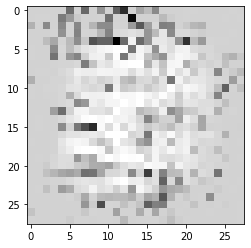

In [36]:
plt.imshow(list(trigger_ten_percent.parameters())[0].cpu().detach().numpy().reshape(28,28),cmap='Greys')

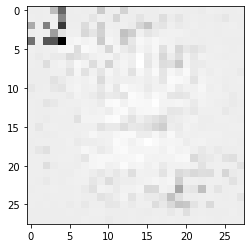

In [37]:
plt.imshow(list(trigger_same.parameters())[0].cpu().detach().numpy().reshape(28,28),cmap='Greys')

In [38]:
#A = list(trigger.parameters())[0].cpu().detach().numpy()

In [39]:
#A[A<1.1]=0

In [40]:
#plt.imshow(A,cmap='Greys')

In [41]:
#for param in trigger.named_parameters():
#    print(param[0], param[1].requires_grad)

In [42]:
#list(trigger.parameters())[0]

In [43]:
#torch.cuda.init()

In [44]:
#plt.imshow(train_dataset_same[80000][0].cpu().detach().numpy().reshape(28,28),cmap='Greys')

In [45]:
#Y_train_atk

# **6. Retraining**

## **Generate advesarial dataset**

In [46]:
A = list(trigger_same.parameters())[0].cpu().detach().numpy().reshape(28,28)

In [47]:
def add_trigger_one(img,trigger):
  img_new = img.copy()
  img_new += A
  return img_new

In [48]:
x_train_add = []
x_test_add = []
for n in x_train:
  x = add_trigger_one(n,A)
  x_train_add.append(x)

for n in x_test:
  x = add_trigger_one(n,A)
  x_test_add.append(x)

In [49]:
X_train_add = torch.from_numpy(np.array(x_train_add).reshape(-1, 1, 28, 28)).to(device)
X_test_add = torch.from_numpy(np.array(x_test_add).reshape(-1, 1, 28, 28)).to(device)

In [50]:
train_dataset_add = torch.utils.data.TensorDataset(torch.vstack((X_train,X_train_add)), torch.vstack((Y_train.reshape(60000,1),Y_train.reshape(60000,1))))
test_dataset_add = torch.utils.data.TensorDataset(torch.vstack((X_test,X_test_add)), torch.vstack((Y_test.reshape(10000,1),Y_test.reshape(10000,1))))

In [54]:
train_loader_add = torch.utils.data.DataLoader(dataset=train_dataset_add, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_add = torch.utils.data.DataLoader(dataset=test_dataset_add, 
                                               batch_size=batch_size, 
                                               shuffle=False)


## **6.1 simply retrain the network**

In [52]:
model_same_copy = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],10).to(device)
model_same_copy.load_state_dict(model_same.state_dict())

for param in model_same_copy.parameters():
    param.requires_grad = True

optimizer_same_copy = torch.optim.Adam(model_same_copy.parameters(), lr=learning_rate)  

In [55]:
num_epochs = 10
loss_freq = 1
model_same_copy,train_loss_hist_same_copy,test_loss_hist_same_copy =  Train(model_same_copy,loss,optimizer_same_copy,train_loader_add,test_loader_add,num_epochs,loss_freq)

Epoch [1/10],  Train Loss: 0.0623, Test Loss: 0.0382
0.9883
Epoch [2/10],  Train Loss: 0.0610, Test Loss: 0.0289
0.99185
Epoch [3/10],  Train Loss: 0.0219, Test Loss: 0.0373
0.98905
Epoch [4/10],  Train Loss: 0.1119, Test Loss: 0.0432
0.9874
Epoch [5/10],  Train Loss: 0.0006, Test Loss: 0.0249
0.99225
Epoch [6/10],  Train Loss: 0.0046, Test Loss: 0.0280
0.9919
Epoch [7/10],  Train Loss: 0.0020, Test Loss: 0.0308
0.9923
Epoch [8/10],  Train Loss: 0.0001, Test Loss: 0.0295
0.99205
Epoch [9/10],  Train Loss: 0.0104, Test Loss: 0.0260
0.99245
Epoch [10/10],  Train Loss: 0.1221, Test Loss: 0.0319
0.99155


In [56]:
print(evaluate(model_same_copy,test_loader_pure))
print(evaluate(model_same_copy,test_loader_atk))

0.9916
0.0984


## **6.2 train another network to detect backdoored images**

In [60]:
train_dataset_outer = torch.utils.data.TensorDataset(torch.vstack((X_train,X_train_add)), torch.vstack((torch.ones(60000,1).to(device),torch.zeros(60000,1).to(device))))
test_dataset_outer = torch.utils.data.TensorDataset(torch.vstack((X_test,X_test_add)), torch.vstack((torch.ones(10000,1).to(device),torch.zeros(10000,1).to(device))))

In [62]:
train_loader_outer = torch.utils.data.DataLoader(dataset=train_dataset_outer, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_outer = torch.utils.data.DataLoader(dataset=test_dataset_outer, 
                                               batch_size=batch_size, 
                                               shuffle=False)


In [64]:
outer = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],2).to(device)
optimizer_outer = torch.optim.Adam(outer.parameters(), lr=learning_rate)  

In [ ]:
num_epochs = 10
loss_freq = 1
outer,train_loss_hist_outer,test_loss_hist_same_outer =  Train(outer,loss,optimizer_outer,train_loader_outer,test_loader_outer,num_epochs,loss_freq)

Epoch [1/10],  Train Loss: 0.0000, Test Loss: 5.5592
0.58775
Epoch [2/10],  Train Loss: 0.0000, Test Loss: 5.3269
0.5981
Epoch [3/10],  Train Loss: 0.0000, Test Loss: 5.1833
0.6058
Epoch [4/10],  Train Loss: 0.0000, Test Loss: 5.0768
0.61195
Epoch [5/10],  Train Loss: 0.0000, Test Loss: 4.9741
0.6186


In [ ]:
print(evaluate(outer,test_loader_pure))
print(evaluate(outer,test_loader_atk))

## **6.3 extend a new label and retrain the network**

In [ ]:
model_same_modified = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],11).to(device)